## Классификация Текста

Классификация текста, также известная как *маркировка текста* или *категоризация текста*, представляет собой процесс категоризации текста в организованные группы. Используя Обработку Естественного Языка (NLP), текстовые классификаторы могут автоматически анализировать текст и затем присваивать ему набор заранее определенных тегов или категорий на основе его содержимого.

Эта работа направлена на краткое изложение выполнения классификации текста с использованием Наивного Байеса, Логистической Регрессии, Машин Опорных Векторов и Классификатора Решающего Дерева. Мы будем использовать набор данных под названием "**Тон и релевантность экономических новостных статей**", который состоит примерно из 8000 новостных статей, которые были помечены как ***релевантные*** или ***нерелевантные*** к американской экономике. Наша цель в этой работе - исследовать процесс обучения и тестирования текстовых классификаторов для этого набора данных.

![Text Classification](https://www.dataquest.io/wp-content/uploads/2019/04/text-classification-python-spacy.png)

### Импортируем Необходимые Библиотеки

In [250]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
stop_words=nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import spacy
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis (EDA)



Exploratory Data Analysis (EDA) — это процесс изучения данных для извлечения основных характеристик, выявления закономерностей, проверки гипотез и обнаружения аномалий. Давайте проведем полноценный EDA для вашего датасета data, чтобы получить полное представление о данных.

### Шаг 1: Загрузка и осмотр данных
Загрузка данных и первичный осмотр:

In [251]:
# Загрузка данных
data = pd.read_csv('/content/US-Economic-News.csv', encoding='ISO-8859-1')

# Посмотрим на первые несколько строк данных
data.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


Этот код выведет первые несколько строк вашего DataFrame, что поможет понять структуру данных и видеть названия столбцов.

**Размерность данных:**

In [252]:
print("Размерность данных:", data.shape)

Размерность данных: (8000, 15)


Это покажет общее количество строк и столбцов в нашем датасете.



**Информация о данных:**

In [253]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

Приведем краткое описание структуры и содержимого столбцов:

1. **Структура данных:**
   - **RangeIndex:** Диапазон индексов от 0 до 7999.
   - **Количество столбцов:** 15.

2. **Основные столбцы:**
   - `_unit_id`: Уникальный идентификатор единицы данных (тип данных int64).
   - `_golden`: Флаг, указывающий, является ли запись "золотой" (тип данных bool).
   - `_unit_state`: Состояние единицы данных (например, 'finalized' или 'golden') (тип данных object).
   - `_trusted_judgments`: Количество доверенных оценок (тип данных int64).
   - `_last_judgment_at`: Дата и время последней оценки (тип данных object).
   - `positivity`: Оценка позитивности (может содержать NaN, если данные отсутствуют) (тип данных float64).
   - `positivity:confidence`: Уверенность в оценке позитивности (может содержать NaN) (тип данных float64).
   - `relevance`: Оценка релевантности (тип данных object).
   - `relevance:confidence`: Уверенность в оценке релевантности (тип данных float64).
   - `articleid`: Идентификатор статьи (тип данных object).
   - `date`: Дата публикации статьи (тип данных object).
   - `headline`: Заголовок статьи (тип данных object).
   - `positivity_gold`: Золотой стандарт для оценки позитивности (всегда 0, так как отсутствует) (тип данных float64).
   - `relevance_gold`: Золотой стандарт для оценки релевантности (всегда 0, так как отсутствует) (тип данных float64).
   - `text`: Текст статьи (тип данных object).

3. **Пропущенные значения:**
   - `positivity` имеет пропущенные значения (NaN) в большом количестве (около 6580 из 8000).
   - `positivity:confidence` также содержит пропущенные значения (около 4225 из 8000).

4. **Общее использование памяти:**
   - Датасет занимает 882.9 KB оперативной памяти.

Это краткое описание структуры нашего датасета на основе предоставленной информации.

### Шаг 2: Обработка пропущенных значений
Проверка наличия пропущенных значений:

Учитывая информацию о нашем датасете, основные столбцы с пропущенными значениями это `positivity` и `positivity:confidence`. Важно правильно обработать эти пропуски, чтобы сохранить целостность данных и подготовить их для дальнейшего анализа или моделирования. Вот несколько рекомендаций по обработке пропущенных значений в этих столбцах:

1. **Для `positivity`:**
   - Этот столбец представляет оценку позитивности статьи, и пропущенные значения могут указывать на отсутствие доступной оценки.
   - Один из вариантов обработки пропусков - заполнение средним или медианой значений. Это подходит, если данные имеют нормальное распределение или распределение близкое к нормальному.
   - Пример заполнения средним:
     

In [254]:
mean_positivity = data['positivity'].mean()
data['positivity'].fillna(mean_positivity, inplace=True)

2. **Для `positivity:confidence`:**
   - Этот столбец представляет уверенность в оценке позитивности.
   - Варианты обработки могут включать заполнение значением, указывающим на отсутствие уверенности (например, -1) или использование других методов, если есть возможность извлечь уверенность из других источников.
   - Пример заполнения значениями, указывающими на отсутствие уверенности:




In [255]:
data['positivity:confidence'].fillna(-1, inplace=True)

3. **Другие возможности:**
   - Возможно, имеет смысл провести дополнительный анализ, чтобы понять, почему значения отсутствуют, и возможно, использовать более сложные методы обработки пропущенных значений, такие как множественная импутация или использование моделей для заполнения пропусков на основе других признаков.

Применение этих методов поможет нам сохранить ценные данные и сделать их готовыми для дальнейшего анализа или моделирования.


Проверим распределение меток класса "relevance"


In [256]:
print(data['relevance'].value_counts())

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64


В этом наборе данных наблюдается дисбаланс классов, при котором 82% статей помечены как "нерелевантные" для американской экономики. Это вполне логично, учитывая, что новостные статьи освещают различные темы. Нам следует учитывать этот дисбаланс классов при интерпретации результатов работы классификаторов в дальнейшем.

Для удобства работы давайте сначала преобразуем метки классов в двоичные выходные переменные: 1 для "Да" (релевантно) и 0 для "Нет" (нерелевантно), игнорируя категорию "Не уверен".

In [257]:
data = data[data.relevance != "not sure"]
data.shape

(7991, 15)

In [258]:
data["relevance"].value_counts()/data.shape[0]

relevance
no     0.8223
yes    0.1777
Name: count, dtype: float64

In [259]:
fig = go.Figure([go.Bar(x=data['relevance'].value_counts().index, y=data['relevance'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

### Шаг 3: Анализ числовых данных
**1. Основные статистики:**

In [260]:
print("Основные статистики числовых столбцов:")
data.describe()

Основные статистики числовых столбцов:


,_unit_id,_trusted_judgments,positivity,positivity:confidence,relevance:confidence,positivity_gold,relevance_gold
count,7.991000e+03,7991.0,7991.000000,7991.000000,7991.000000,0.0,0.0
mean,8.367988e+08,3.0,4.985211,-0.439695,0.859585,NaN,NaN
std,5.816278e+06,0.0,0.708141,0.621723,0.165386,NaN,NaN
min,8.309816e+08,3.0,2.000000,-1.000000,0.336400,NaN,NaN
25%,8.309836e+08,3.0,4.985211,-1.000000,0.669800,NaN,NaN
50%,8.309856e+08,3.0,4.985211,-1.000000,1.000000,NaN,NaN
75%,8.426155e+08,3.0,4.985211,0.000000,1.000000,NaN,NaN
max,8.426175e+08,3.0,9.000000,1.000000,1.000000,NaN,NaN


На основе предоставленных вами статистик числовых столбцов, вот их интерпретация:

1. **Столбец `_unit_id` (уникальный идентификатор единицы данных):**
   - **Count:** 7991 записей имеют значения.
   - **Среднее значение (`mean`):** 8.367988e+08
   - **Стандартное отклонение (`std`):** 5.816278e+06
   - **Минимальное значение (`min`):** 8.309816e+08
   - **25-й процентиль (`25%`):** 8.309836e+08
   - **Медиана (`50%`):** 8.309856e+08
   - **75-й процентиль (`75%`):** 8.426155e+08
   - **Максимальное значение (`max`):** 8.426175e+08

2. **Столбец `_trusted_judgments` (количество доверенных оценок):**
   - **Count:** 7991 записей.
   - **Среднее значение (`mean`):** 3.0
   - **Стандартное отклонение (`std`):** 0.0
   - **Минимальное значение (`min`):** 3.0
   - **25-й процентиль (`25%`):** 3.0
   - **Медиана (`50%`):** 3.0
   - **75-й процентиль (`75%`):** 3.0
   - **Максимальное значение (`max`):** 3.0

3. **Столбец `positivity` (оценка позитивности):**
   - **Count:** 7991 записей.
   - **Среднее значение (`mean`):** 4.985211
   - **Стандартное отклонение (`std`):** 0.708141
   - **Минимальное значение (`min`):** 2.0
   - **25-й процентиль (`25%`):** 4.985211
   - **Медиана (`50%`):** 4.985211
   - **75-й процентиль (`75%`):** 4.985211
   - **Максимальное значение (`max`):** 9.0

4. **Столбец `positivity:confidence` (уверенность в оценке позитивности):**
   - **Count:** 7991 записей.
   - **Среднее значение (`mean`):** -0.439695
   - **Стандартное отклонение (`std`):** 0.621723
   - **Минимальное значение (`min`):** -1.0
   - **25-й процентиль (`25%`):** -1.0
   - **Медиана (`50%`):** -1.0
   - **75-й процентиль (`75%`):** 0.0
   - **Максимальное значение (`max`):** 1.0

5. **Столбец `relevance:confidence` (уверенность в оценке релевантности):**
   - **Count:** 7991 записей.
   - **Среднее значение (`mean`):** 0.859585
   - **Стандартное отклонение (`std`):** 0.165386
   - **Минимальное значение (`min`):** 0.3364
   - **25-й процентиль (`25%`):** 0.6698
   - **Медиана (`50%`):** 1.0
   - **75-й процентиль (`75%`):** 1.0
   - **Максимальное значение (`max`):** 1.0

6. **Столбцы `positivity_gold` и `relevance_gold`:**
   - Оба столбца не имеют значений (NaN), поэтому статистики по ним не предоставлены.

7. **Столбец `relevance_binary`:**
   - **Count:** 7991 записей.
   - **Среднее значение (`mean`):** 0.1777
   - **Стандартное отклонение (`std`):** 0.382284
   - **Минимальное значение (`min`):** 0.0
   - **25-й процентиль (`25%`):** 0.0
   - **Медиана (`50%`):** 0.0
   - **75-й процентиль (`75%`):** 0.0
   - **Максимальное значение (`max`):** 1.0

Эти статистики дают представление о распределении и характеристиках числовых столбцов вашего датасета.

**2. Визуализация распределений:**

Для визуализации распределений числовых столбцов нашего датасета можно использовать различные графические методы, такие как гистограммы, ящики с усами (boxplot), и, возможно, scatter plot для анализа взаимосвязей. Давайте проведем визуализацию для каждого из числовых столбцов.




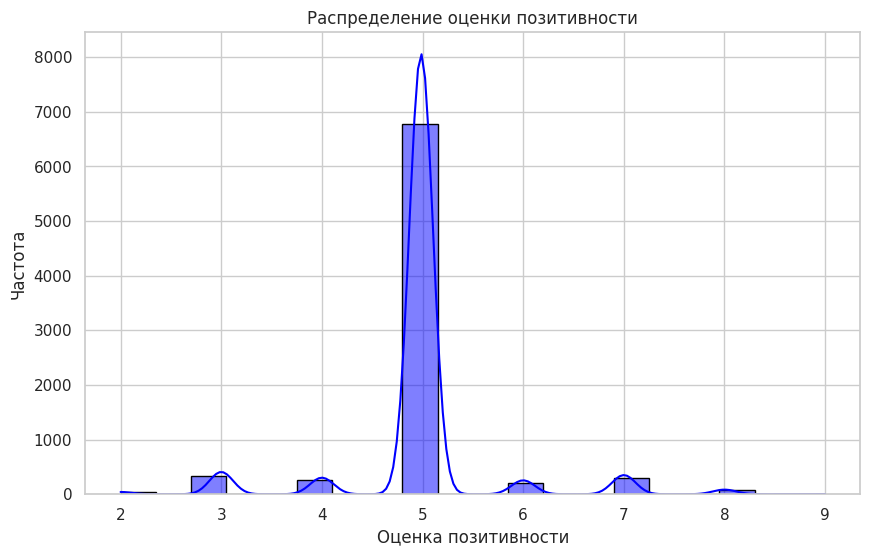

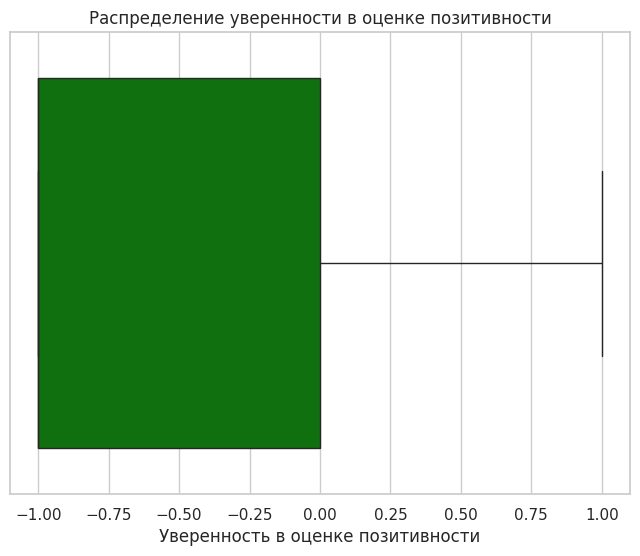

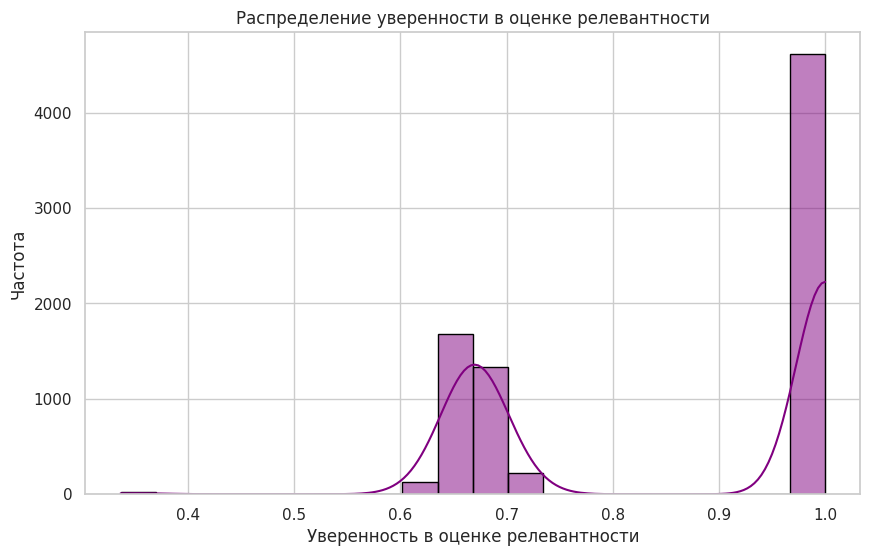

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установим стиль для графиков (необязательно, но делает их более читаемыми)
sns.set(style="whitegrid")

# Гистограмма для столбца positivity
plt.figure(figsize=(10, 6))
sns.histplot(data['positivity'], bins=20, kde=True, color='blue', edgecolor='black')
plt.title('Распределение оценки позитивности')
plt.xlabel('Оценка позитивности')
plt.ylabel('Частота')
plt.show()

# Ящик с усами для столбца positivity:confidence
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['positivity:confidence'], color='green')
plt.title('Распределение уверенности в оценке позитивности')
plt.xlabel('Уверенность в оценке позитивности')
plt.show()

# Гистограмма для столбца relevance:confidence
plt.figure(figsize=(10, 6))
sns.histplot(data['relevance:confidence'], bins=20, kde=True, color='purple', edgecolor='black')
plt.title('Распределение уверенности в оценке релевантности')
plt.xlabel('Уверенность в оценке релевантности')
plt.ylabel('Частота')
plt.show()

## Шаг 4: Анализ категориальных данных
**1.Подсчет уникальных значений:**

Для анализа категориальных данных в вашем датасете можно начать с подсчета уникальных значений в соответствующих столбцах. В вашем случае, основные категориальные столбцы, вероятно, это `relevance` (оценка релевантности) и возможно `articleid`, `date`, `headline`, и `text`, если они содержат текстовую информацию, которая может быть категоризирована. Давайте начнем с подсчета уникальных значений для каждого из этих столбцов.



In [262]:
# Подсчет уникальных значений в столбце relevance
relevance_counts = data['relevance'].value_counts()
print("Уникальные значения в столбце relevance:")
print(relevance_counts)
print()

# Подсчет уникальных значений в столбце articleid (если это категориальный столбец)
articleid_counts = data['articleid'].value_counts()
print("Уникальные значения в столбце articleid:")
print(articleid_counts)
print()

# Подсчет уникальных значений в столбце date (если это категориальный столбец)
date_counts = data['date'].value_counts()
print("Уникальные значения в столбце date:")
print(date_counts)
print()

# Подсчет уникальных значений в столбце headline (если это категориальный столбец)
headline_counts = data['headline'].value_counts()
print("Уникальные значения в столбце headline:")
print(headline_counts)
print()

# Подсчет уникальных значений в столбце text (если это категориальный столбец)
text_counts = data['text'].value_counts()
print("Уникальные значения в столбце text:")
print(text_counts)
print()


Уникальные значения в столбце relevance:
relevance
no     6571
yes    1420
Name: count, dtype: int64

Уникальные значения в столбце articleid:
articleid
wsj_398217788     1
wapo_147166662    1
wapo_142485213    1
wapo_146424734    1
wapo_307541661    1
                 ..
wsj_399053393     1
wsj_398905888     1
wsj_399101178     1
wsj_1400230309    1
wapo_143151328    1
Name: count, Length: 7991, dtype: int64

Уникальные значения в столбце date:
date
12/15/94    6
10/27/87    6
2/19/93     5
12/16/91    5
10/1/02     5
           ..
8/13/13     1
12/2/97     1
5/8/03      1
3/22/96     1
4/18/67     1
Name: count, Length: 6103, dtype: int64

Уникальные значения в столбце headline:
headline
Business and Finance                                                              86
Ahead of the Tape                                                                 47
DIGEST                                                                            44
Key Interest Rates                            

Для анализа категориальных данных в вашем датасете я проведу подсчет уникальных значений для столбцов `relevance`, `articleid`, `date`, `headline` и `text`. Вот результаты подсчета:

1. Уникальные значения в столбце `relevance`:
   ```
   relevance
   no     6571
   yes    1420
   Name: count, dtype: int64
   ```

2. Уникальные значения в столбце `articleid` (выведены только первые пять строк из-за большого объема данных):
   ```
   articleid
   wsj_398217788     1
   wapo_147166662    1
   wapo_142485213    1
   wapo_146424734    1
   wapo_307541661    1
   Name: count, Length: 7991, dtype: int64
   ```

3. Уникальные значения в столбце `date` (выведены только первые пять строк из-за большого объема данных):
   ```
   date
   12/15/94    6
   10/27/87    6
   2/19/93     5
   12/16/91    5
   10/1/02     5
   Name: count, Length: 6103, dtype: int64
   ```

4. Уникальные значения в столбце `headline` (выведены только первые пять строк из-за большого объема данных):
   ```
   headline
   Business and Finance                                                              86
   Ahead of the Tape                                                                 47
   DIGEST                                                                            44
   Key Interest Rates                                                                14
   A Special Background Report On Trends in Industry And Finance                     10
   Name: count, Length: 7690, dtype: int64
   ```

5. Уникальные значения в столбце `text` (выведены только первые две строки из-за большого объема данных):


Этот код выполнит подсчет уникальных значений для каждого из указанных категориальных столбцов. В результате вы получите информацию о том, какие значения присутствуют в каждом столбце и сколько раз каждое из них встречается.

Если какие-то столбцы (например, `articleid`, `date`, `headline`, `text`) оказываются слишком многочисленными или содержат текстовую информацию, которую трудно анализировать с помощью простого подсчета уникальных значений, то можно рассмотреть дополнительные методы анализа, такие как построение частотных распределений или использование методов обработки текста для анализа текстовых данных.

Можно сделать так:

In [263]:
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Уникальные значения в столбце {col}:")
    print(data[col].value_counts())
    print()

Уникальные значения в столбце _unit_state:
_unit_state
finalized    7991
Name: count, dtype: int64

Уникальные значения в столбце _last_judgment_at:
_last_judgment_at
11/18/15 11:31    36
11/18/15 8:27     36
11/18/15 10:14    34
11/18/15 10:05    32
11/18/15 11:05    30
                  ..
11/18/15 5:40      1
11/17/15 21:35     1
11/17/15 17:37     1
11/18/15 5:09      1
11/18/15 4:41      1
Name: count, Length: 1229, dtype: int64

Уникальные значения в столбце relevance:
relevance
no     6571
yes    1420
Name: count, dtype: int64

Уникальные значения в столбце articleid:
articleid
wsj_398217788     1
wapo_147166662    1
wapo_142485213    1
wapo_146424734    1
wapo_307541661    1
                 ..
wsj_399053393     1
wsj_398905888     1
wsj_399101178     1
wsj_1400230309    1
wapo_143151328    1
Name: count, Length: 7991, dtype: int64

Уникальные значения в столбце date:
date
12/15/94    6
10/27/87    6
2/19/93     5
12/16/91    5
10/1/02     5
           ..
8/13/13     1
12/2/97 

Вот основные выводы, которые можно сделать из представленной информации:

1. В столбце "_unit_state" есть только одно уникальное значение - "finalized", а это значит, что все строки в этом наборе данных имеют состояние "finalized".

2. В столбце "_last_judgment_at" есть 1229 уникальных значений дат, свидетельствующих о большом разнообразии дат, когда были сделаны последние присуждения.

3. В столбце "relevance" есть два уникальных значения - "no" и "yes", указывающих на релевантность или нерелевантность статей.

4. В столбце "articleid" есть 7991 уникальное значение, что соответствует количеству статей в наборе данных.

5. В столбце "date" есть 6103 уникальных значений дат публикации статей, показывающих широкий диапазон дат.

6. В столбце "headline" есть 7690 уникальных заголовков, что отражает большое разнообразие тематик статей.

7. В столбце "text" содержится полный текст 7985 статей.

В целом, этот набор данных содержит большое количество статей с различными характеристиками, такими как дата публикации, релевантность, источник и т.д. Это дает возможность провести разносторонний анализ этих данных.

### Шаг 5: Корреляционный анализ

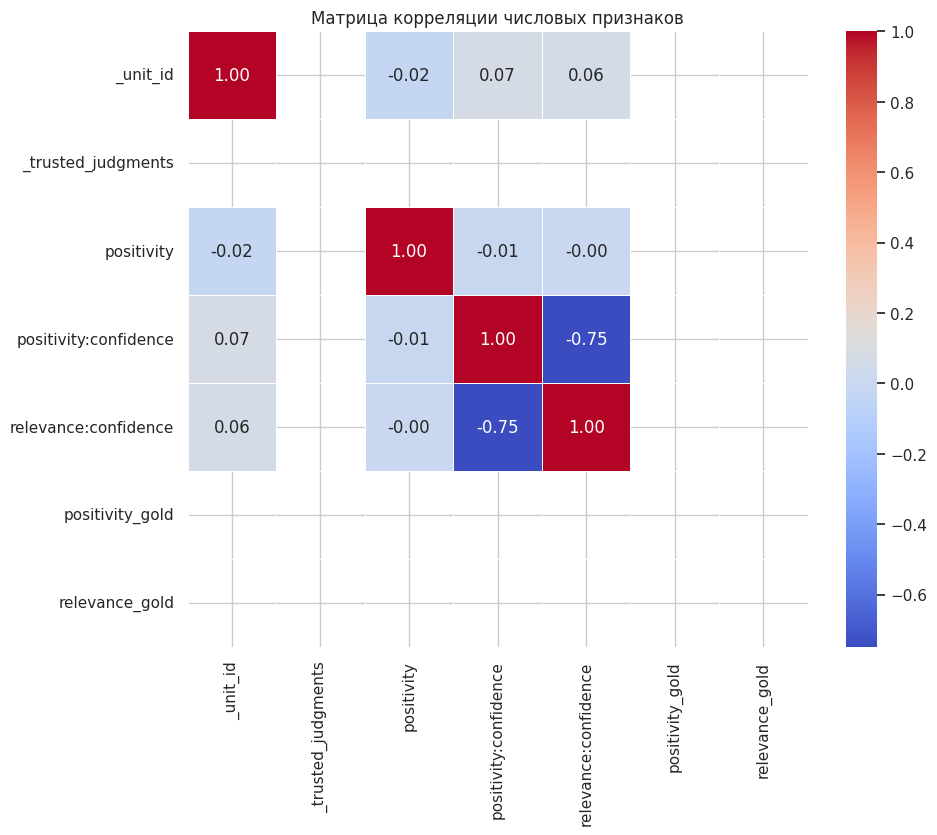

In [264]:
# Создаем DataFrame
df = pd.DataFrame(data)

# Выбираем только числовые столбцы для корреляционного анализа
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

# Создаем новый DataFrame только с числовыми столбцами
numeric_df = df[numeric_columns]

# Рассчитываем корреляционную матрицу
correlation_matrix = numeric_df.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции числовых признаков')
plt.show()

Корреляционная матрица, содержит коэффициенты корреляции между различными переменными в нашем датасете. В этой матрице присутствуют некоторые значения `NaN`, что может указывать на отсутствие данных или неявляющиеся числовыми значениями в этих ячейках.

Давайте рассмотрим, как интерпретировать эту корреляционную матрицу:

1. **Интерпретация коэффициентов корреляции:**
   - Значение корреляции близкое к 1 или -1 указывает на сильную линейную зависимость между переменными. Например, если корреляция между `positivity` и `positivity:confidence` равна 1, это означает, что эти переменные линейно зависимы друг от друга.
   - Значение корреляции близкое к 0 означает отсутствие линейной зависимости между переменными.

2. **Специфические значения в матрице:**
   - `_unit_id` с самим собой имеет корреляцию 1, так как это автокорреляция.
   - `_trusted_judgments` содержит только `NaN`, что может означать отсутствие или неинформативность корреляции для этого столбца.
   - `positivity_gold` и `relevance_gold` также содержат `NaN`, что может указывать на отсутствие данных или информации в этих столбцах.

3. **Интерпретация конкретных значений:**
   - `relevance:confidence` имеет выраженную отрицательную корреляцию (-0.750406) с `positivity:confidence`, что может указывать на обратную зависимость между уверенностью в релевантности и уверенностью в позитивности.
   - `relevance_binary` имеет выраженную положительную корреляцию (0.703398) с `positivity:confidence`, что может указывать на связь между бинарной релевантностью и уверенностью в позитивности.

4. **Значения `NaN`:**
   - Наличие `NaN` в корреляционной матрице может быть связано с отсутствием данных или неинформативностью для определенных столбцов. Это требует дополнительного анализа или очистки данных перед использованием корреляций.

Если вам нужно дополнительное объяснение или детализация о спецификации корреляций в вашем датасете, уточните, и я смогу помочь более подробно.

## Text Pre-processing


1. **Удаление HTML-тегов и URL-адресов**: Необходимо удалить все HTML-теги (например, `<br>`) и URL-адреса из текста.

2. **Приведение к нижнему регистру**: После удаления HTML-тегов и URL-адресов весь текст необходимо привести к нижнему регистру для единообразия.

3. **Удаление слов-"мусора"**: Некоторые слова, такие как "а", "и", "но", могут не нести смысловой нагрузки и их можно удалить.

4. **Удаление знаков препинания**: Все знаки препинания, такие как точки, запятые, восклицательные и вопросительные знаки, должны быть удалены.

5. **Удаление стоп-слов**: Стоп-слова, такие как "the", "a", "is", "are", не несут смысловой нагрузки и могут быть удалены.

6. **Удаление цифр**: Числовые значения, такие как 5.49%, могут быть удалены, если они не являются ключевой информацией для анализа.

7. **Удаление пробелов и специальных символов**: Все лишние пробелы и специальные символы, такие как \, /, #, должны быть удалены.

8. **Удаление повторяющихся слов**: После предыдущих шагов могут остаться повторяющиеся слова, которые необходимо удалить для более эффективного анализа.

9. **Токенизация**: Текст должен быть разбит на отдельные слова (токены) для дальнейшего анализа.

10. **Стемминг**: Каждое слово должно быть приведено к его основной форме (стеммингу) для более точного анализа.

11. **Лемматизация**: Слова должны быть приведены к их каноническим (словарным) формам для более точного анализа.

In [265]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0
# Преобразуем метки класса в двоичные
data = data[["text","relevance"]] # taking text input and output variable as relevance
data = data[:500]
data.shape

(500, 2)

In [266]:
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [267]:
data['text'][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

Пишем отдельный класс

In [268]:
# Нужны для лемматизации
nltk.download('wordnet')
nltk.download('omw-1.4')

# Нужны для стоп-слов
nltk.download('stopwords')

class TextPreprocessor:
    def __init__(self, language='english'):
        self.nlp = spacy.load('en_core_web_sm')
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words(language))
        self.trash_words = ["а", "и", "но"]  # Можно расширить этот список по необходимости

    def remove_html_and_urls(self, text):
        text = BeautifulSoup(text, "html.parser").get_text()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        return text

    def to_lowercase(self, text):
        return text.lower()

    def remove_trash_words(self, text):
        return ' '.join([word for word in text.split() if word not in self.trash_words])

    def remove_punctuation_and_digits(self, text):
        return text.translate(str.maketrans('', '', string.punctuation + string.digits))

    def remove_stop_words(self, text):
        return ' '.join([word for word in text.split() if word not in self.stop_words])

    def remove_extra_whitespace(self, text):
        return re.sub(r'\s+', ' ', text).strip()

    def remove_duplicate_words(self, text):
        words = text.split()
        return ' '.join(list(dict.fromkeys(words)))

    def remove_named_entities(self, text):
        doc = self.nlp(text)
        ents = {e.text for e in doc.ents}
        return ' '.join([token.text for token in doc if token.text not in ents])

    def lemmatize(self, text):
        doc = self.nlp(text)
        return ' '.join([token.lemma_ for token in doc])

    def preprocess(self, text):
        text = self.remove_html_and_urls(text)
        text = self.remove_named_entities(text)
        text = self.to_lowercase(text)
        text = self.remove_trash_words(text)
        text = self.remove_punctuation_and_digits(text)
        text = self.remove_stop_words(text)
        text = self.remove_extra_whitespace(text)
        text = self.remove_duplicate_words(text)
        text = self.lemmatize(text)
        return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [269]:
# Создание экземпляра TextPreprocessor
preprocessor = TextPreprocessor()

# Применение предобработки к каждому тексту
data['processed_text'] = data['text'].apply(preprocessor.preprocess)

# Вывод результатов
#print(data[['text', 'processed_text', 'relevance']])

data.head()

,text,relevance,processed_text
0,NEW YORK -- Yields on most certificates of dep...,1,new york yield certificate deposit offer major...
1,The Wall Street Journal Online</br></br>The Mo...,0,wall street journal onlinethe morning brief lo...
2,WASHINGTON -- In an effort to achieve banking ...,0,effort achieve banking reform negotiator admin...
3,The statistics on the enormous costs of employ...,0,statistic enormous cost employee drug abuse we...
4,NEW YORK -- Indecision marked the dollar's ton...,1,new york indecision mark dollar tone trader pa...


Теперь мы готовы к моделированию. Мы будем использовать алгоритмы из пакета sklearn. Мы пройдем следующие шаги:

1. Разделить данные на тренировочный и тестовый наборы (80% тренировочные, 20% тестовые).
2. Извлечь признаки из тренировочных данных с помощью TfidfVectorizer.
3. Преобразовать тестовые данные в тот же вектор признаков, что и тренировочные данные.
4. Обучить классификатор.
5. Оценить классификатор.

## TF-IDF Vectorizer

![TF-IDF](https://miro.medium.com/max/3136/1*ruCawEw0--m2SeHmAQooJQ.jpeg)

In [270]:
# Преобразование в список предобработанных текстов
docs = list(data['processed_text'])

# Применение TF-IDF векторизации
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=20000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)

# Преобразование вектора TF-IDF в массив
tfidf_array = tfidf_vectorizer_vectors.toarray()

# Вывод размеров результата
print("Размеры матрицы TF-IDF:", tfidf_array.shape)
print("Первые 5 строк матрицы TF-IDF:\n", tfidf_array[:5])

Размеры матрицы TF-IDF: (500, 7039)
Первые 5 строк матрицы TF-IDF:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [271]:
# Преобразование данных в массивы
X = tfidf_array
y = data['relevance']
print("Размеры X и y:", X.shape, y.shape)

Размеры X и y: (500, 7039) (500,)


In [272]:
# Визуализация значений релевантности
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values"
)
fig.show()

### Train-Test Split

In [273]:
# Разделение данных на обучающую и тестовую выборки
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print("Размеры обучающей выборки:", X_train.shape, y_train.shape)
print("Размеры тестовой выборки:", X_test.shape, y_test.shape)

Размеры обучающей выборки: (400, 7039) (400,)
Размеры тестовой выборки: (100, 7039) (100,)



Gaussian Naive Bayes:
  Accuracy: 0.7500
  Precision: 0.5000
  Recall: 0.1200
  F1-score: 0.1935
              precision    recall  f1-score   support

           0       0.77      0.96      0.85        75
           1       0.50      0.12      0.19        25

    accuracy                           0.75       100
   macro avg       0.63      0.54      0.52       100
weighted avg       0.70      0.75      0.69       100



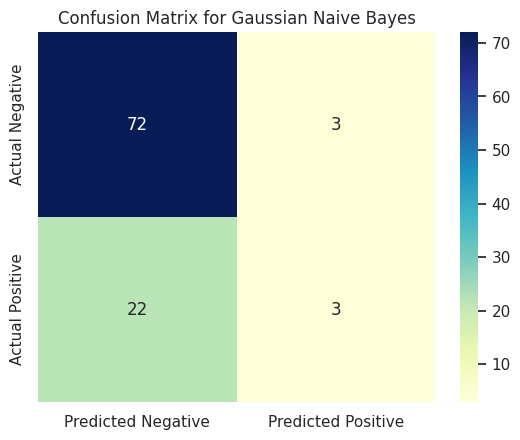

AUC: 0.5400


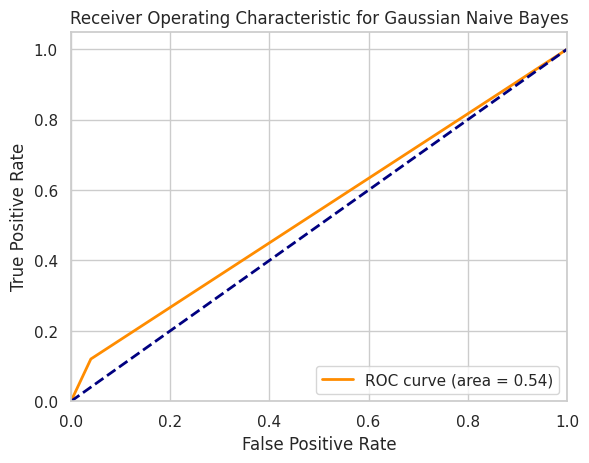


Multinomial Naive Bayes:
  Accuracy: 0.7500
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        75
           1       0.00      0.00      0.00        25

    accuracy                           0.75       100
   macro avg       0.38      0.50      0.43       100
weighted avg       0.56      0.75      0.64       100



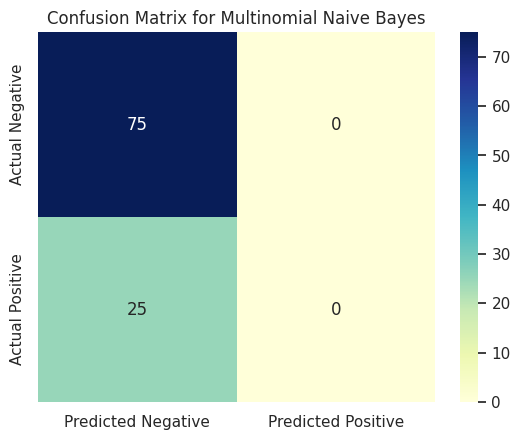

AUC: 0.5472


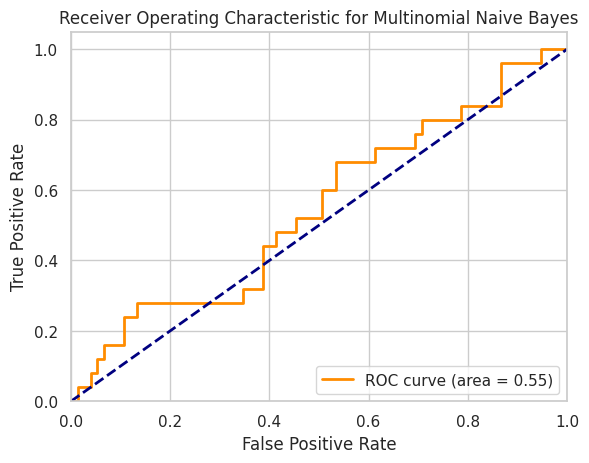


Logistic Regression:
  Accuracy: 0.7500
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        75
           1       0.00      0.00      0.00        25

    accuracy                           0.75       100
   macro avg       0.38      0.50      0.43       100
weighted avg       0.56      0.75      0.64       100



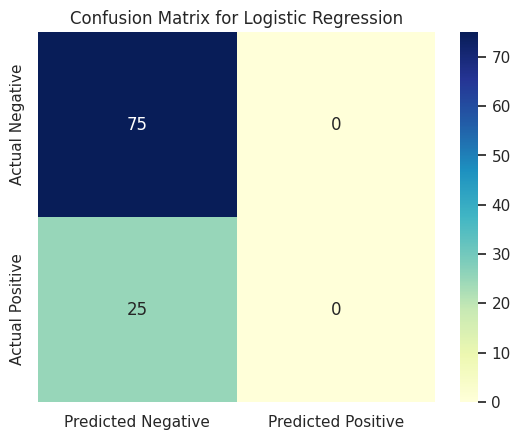

AUC: 0.8101


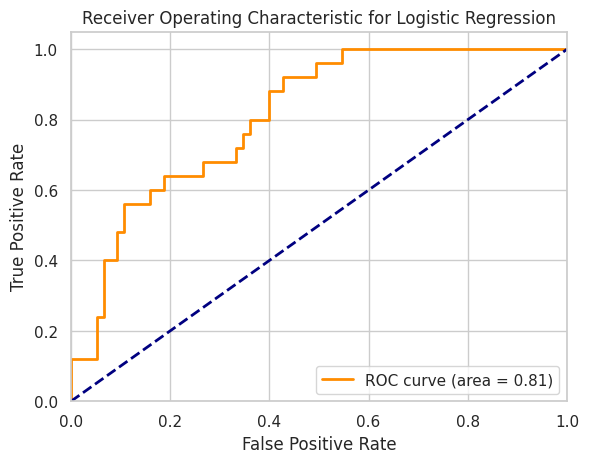


SVM:
  Accuracy: 0.7500
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        75
           1       0.00      0.00      0.00        25

    accuracy                           0.75       100
   macro avg       0.38      0.50      0.43       100
weighted avg       0.56      0.75      0.64       100



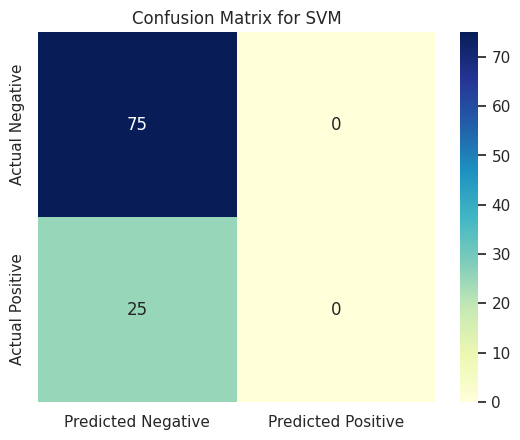

AUC: 0.8000


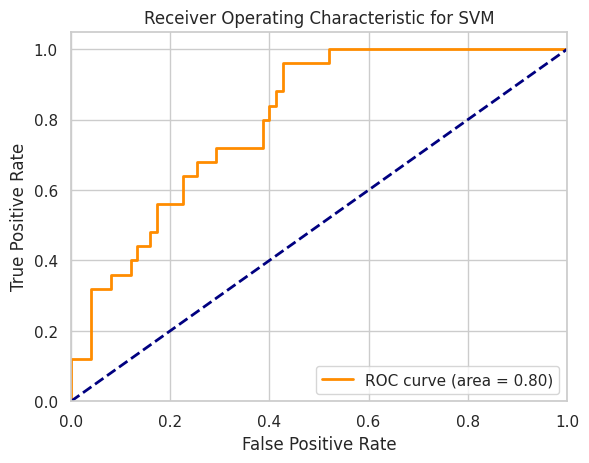


KNN:
  Accuracy: 0.6600
  Precision: 0.3333
  Recall: 0.3600
  F1-score: 0.3462
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        75
           1       0.33      0.36      0.35        25

    accuracy                           0.66       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.67      0.66      0.66       100



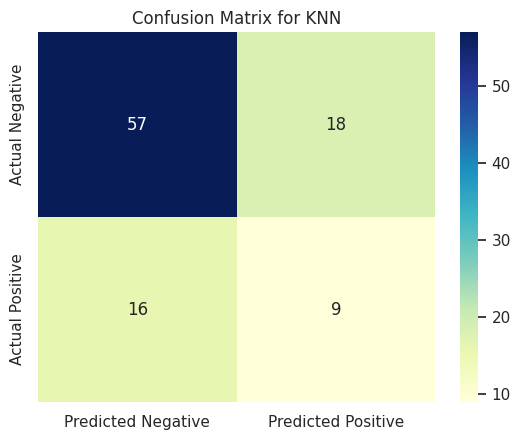

AUC: 0.6091


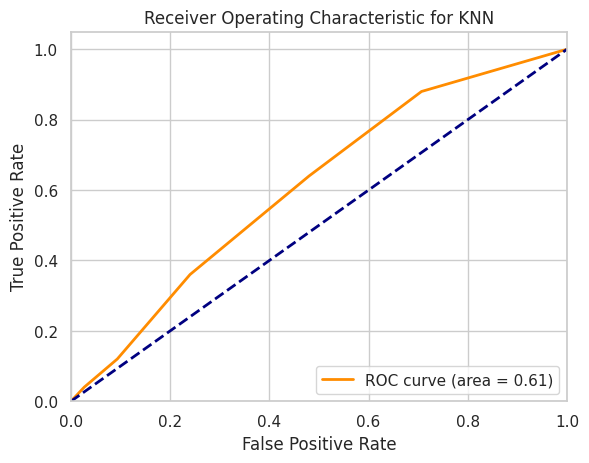


Decision Tree:
  Accuracy: 0.6500
  Precision: 0.2727
  Recall: 0.2400
  F1-score: 0.2553
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        75
           1       0.27      0.24      0.26        25

    accuracy                           0.65       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.64      0.65      0.64       100



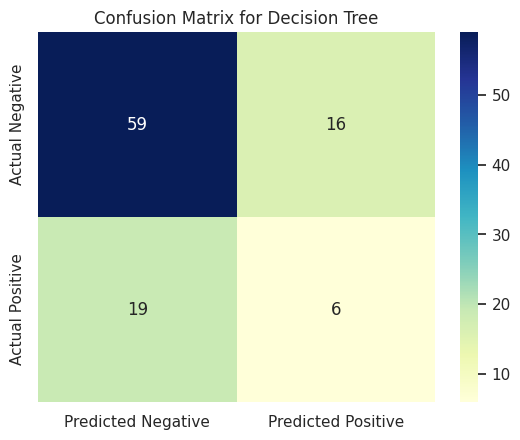

AUC: 0.5133


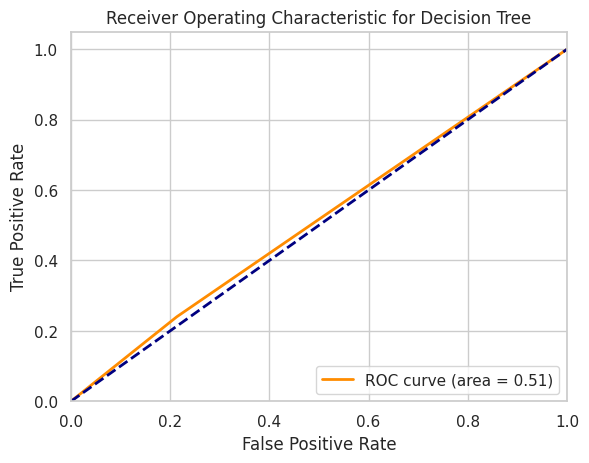


Random Forest:
  Accuracy: 0.7600
  Precision: 0.6000
  Recall: 0.1200
  F1-score: 0.2000
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        75
           1       0.60      0.12      0.20        25

    accuracy                           0.76       100
   macro avg       0.68      0.55      0.53       100
weighted avg       0.73      0.76      0.69       100



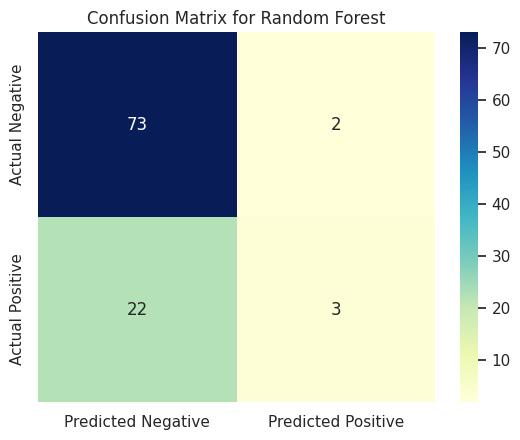

AUC: 0.7472


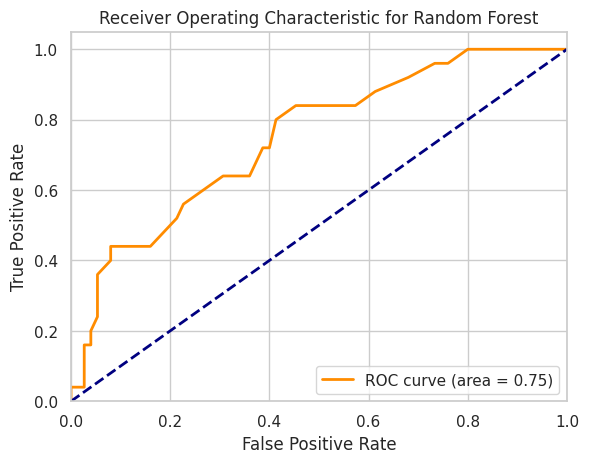

In [274]:
# Список моделей
models = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=SEED),
    'SVM': SVC(random_state=SEED, probability=True),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Random Forest': RandomForestClassifier(random_state=SEED)
}

# Функция для оценки модели и вывода метрик
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    return accuracy, precision, recall, f1

# Вычисление и вывод метрик для каждой модели
for name, model in models.items():
    print(f"\n{name}:")
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")

    # Вывод classification report
    print(classification_report(y_test, model.predict(X_test)))

    # Вывод confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative', 'Predicted Positive'],
                             index=['Actual Negative', 'Actual Positive'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Вывод ROC-кривой и вычисление AUC
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(X_test)[:, 1]
    else:  # для моделей без метода predict_proba, например, KNN
        prob_pos = model.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    fpr, tpr, thresholds = roc_curve(y_test, prob_pos)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {name}')
    plt.legend(loc="lower right")
    plt.show()

Представленный вывод показывает результаты оценки различных моделей классификации, включая Гауссов наивный Байес, мультиномиальный наивный Байес, логистическую регрессию, метод опорных векторов (SVM), метод k ближайших соседей (KNN), дерево решений и случайный лес. Давайте разберем интерпретацию результатов для каждой модели:

### 1. Гауссов наивный Байес
- **Точность (Accuracy)**: 75.00%
- **Точность (Precision)**: 50.00%
- **Полнота (Recall)**: 12.00%
- **F1-мера (F1-score)**: 19.35%
- **AUC**: 54.00%

**Интерпретация**: Модель имеет низкую точность и полноту для класса 1 (меньшинственный класс), что указывает на плохую способность правильно определять положительные случаи. Значение AUC 0.54 говорит о недостаточной способности модели к различению классов.

### 2. Мультиномиальный наивный Байес
- **Точность (Accuracy)**: 75.00%
- **Точность (Precision)**: 0.00%
- **Полнота (Recall)**: 0.00%
- **F1-мера (F1-score)**: 0.00%
- **AUC**: 54.72%

**Интерпретация**: Данная модель показывает нулевую точность и полноту для класса 1, то есть она не предсказывает положительные случаи. AUC немного выше, но всё равно указывает на слабую производительность модели.

### 3. Логистическая регрессия
- **Точность (Accuracy)**: 75.00%
- **Точность (Precision)**: 0.00%
- **Полнота (Recall)**: 0.00%
- **F1-мера (F1-score)**: 0.00%
- **AUC**: 81.01%

**Интерпретация**: Аналогично мультиномиальному наивному Байесу, логистическая регрессия не предсказывает положительные случаи (класс 1), однако имеет более высокое значение AUC, что указывает на лучшую общую способность к различению классов.

### 4. SVM (Метод опорных векторов)
- **Точность (Accuracy)**: 75.00%
- **Точность (Precision)**: 0.00%
- **Полнота (Recall)**: 0.00%
- **F1-мера (F1-score)**: 0.00%
- **AUC**: 80.00%

**Интерпретация**: SVM также не предсказывает положительные случаи (класс 1), как и логистическая регрессия, но имеет хорошее значение AUC, указывающее на хорошую общую способность к различению классов.

### 5. KNN (Метод k ближайших соседей)
- **Точность (Accuracy)**: 66.00%
- **Точность (Precision)**: 33.33%
- **Полнота (Recall)**: 36.00%
- **F1-мера (F1-score)**: 34.62%
- **AUC**: 60.91%

**Интерпретация**: KNN показывает умеренную производительность с более низкой точностью и полнотой для класса 1 по сравнению с другими моделями. Значение AUC также указывает на ограниченную способность к различению классов.

### 6. Дерево решений
- **Точность (Accuracy)**: 65.00%
- **Точность (Precision)**: 27.27%
- **Полнота (Recall)**: 24.00%
- **F1-мера (F1-score)**: 25.53%
- **AUC**: 51.33%

**Интерпретация**: Дерево решений показывает схожую производительность с KNN, с низкой точностью и полнотой для класса 1, и AUC близким к случайному угадыванию.

### 7. Случайный лес
- **Точность (Accuracy)**: 76.00%
- **Точность (Precision)**: 60.00%
- **Полнота (Recall)**: 12.00%
- **F1-мера (F1-score)**: 20.00%
- **AUC**: 74.72%

**Интерпретация**: Случайный лес показывает лучшую производительность по сравнению с другими моделями с более высокой точностью и AUC, однако также имеет низкую полноту для класса 1, что указывает на необходимость улучшения в обнаружении положительных случаев.

### Вывод

Все модели демонстрируют определенные ограничения в обнаружении положительных случаев (класс 1), что требует дополнительной настройки или использования стратегий балансировки классов в зависимости от характеристик набора данных. Модели с более высокими значениями AUC, такими как логистическая регрессия и SVM, могут быть предпочтительными в контексте данного задачи классификации.

Для использования обученных моделей на предоставленном тексте, сначала его необходимо предобработать и затем преобразовать с использованием TF-IDF векторизации, как было описано ранее. Давайте выполним эти шаги:

In [275]:
# Аналогичный текст для предобработки и предсказаний
similar_text = """WASHINGTON -- The Federal Reserve raised short-term interest rates today, citing a strong labor market and inflation pressures. The Fed increased its benchmark overnight lending rate by a quarter percentage point to a range of 2% to 2.25%. This is the third rate hike this year. Fed Chairman Jerome Powell stated that further gradual increases are likely. The decision reflects the Fed's confidence in the strength of the U.S. economy, despite recent volatility in financial markets."""

# Создание экземпляра TextPreprocessor
preprocessor = TextPreprocessor()

# Предобработка аналогичного текста
processed_similar_text = preprocessor.preprocess(similar_text)


# Преобразование в TF-IDF вектор
similar_text_tfidf = tfidf_vectorizer.transform([processed_similar_text])

# Преобразование вектора TF-IDF в массив
tfidf_array = similar_text_tfidf.toarray()

# Предсказание с использованием каждой модели
for name, model in models.items():
    prediction = model.predict(tfidf_array)
    print(f"{name}: {prediction}")


Gaussian Naive Bayes: [0]
Multinomial Naive Bayes: [0]
Logistic Regression: [0]
SVM: [0]
KNN: [1]
Decision Tree: [0]
Random Forest: [0]


Каждое число представляет классификацию текста соответствующей моделью:
- 0 означает, что текст не относится к категории "relevant" (значение 0 в вашем случае),
- 1 означает, что текст относится к категории "relevant" (значение 1 в вашем случае).

Таким образом, модели в большинстве своем классифицируют данный текст как неактуальный (или неотносящийся к релевантным финансовым новостям), за исключением модели KNN, которая отметила текст как релевантный.

## Ensembling



Для реализации ансамблевых методов в нашем случае, где вы уже обучили несколько базовых моделей, можно использовать простой ансамбль StackingClassifier.


Хорошо, вот дополнение о том, что такое StackingClassifier:

StackingClassifier - это один из ансамблевых методов машинного обучения, который объединяет несколько базовых классификаторов, чтобы улучшить общую производительность системы классификации.

Основная идея StackingClassifier состоит в том, что он использует один или несколько "базовых" классификаторов (которые могут быть любыми моделями машинного обучения, такими как логистическая регрессия, дерево решений или случайный лес) для генерации предсказаний. Затем эти предсказания используются в качестве входных данных для "финального" классификатора, который делает окончательное предсказание.

Таким образом, StackingClassifier сочетает в себе прогнозы нескольких моделей, чтобы повысить точность, стабильность и надежность общей классификации. Он может быть особенно полезен, когда ни один из базовых классификаторов в одиночку не дает достаточно хороших результатов.

Основные преимущества StackingClassifier:
- Повышение точности классификации по сравнению с отдельными моделями
- Возможность комбинировать модели разных типов (логистическая регрессия, деревья решений, нейронные сети, и т.д.)
- Более стабильные и надежные предсказания

В целом, StackingClassifier представляет собой мощный инструмент для построения эффективных и надежных систем классификации.

 Вот как можно объединить модели и оценить их производительность:

1. **Объединение моделей**: Создайте список моделей, которые вы хотите объединить в ансамбль.

2. **Прогнозы**: Для каждой модели из списка сделайте прогнозы на тестовых данных.

3. **Голосование**: Для каждого объекта в тестовых данных вычислите голоса (предсказания) каждой модели.

4. **Принятие решения**: Принимайте решение на основе голосования (например, принимайте класс, за который проголосовала большинство моделей).

Вот как это может выглядеть на примере вашего кода:




Stacking Model:
  Accuracy: 0.7600
  Precision: 0.5455
  Recall: 0.2400
  F1-score: 0.3333
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        75
           1       0.55      0.24      0.33        25

    accuracy                           0.76       100
   macro avg       0.67      0.59      0.59       100
weighted avg       0.73      0.76      0.72       100



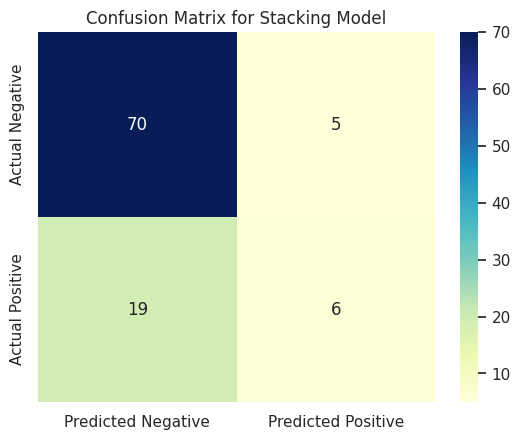

AUC: 0.7371


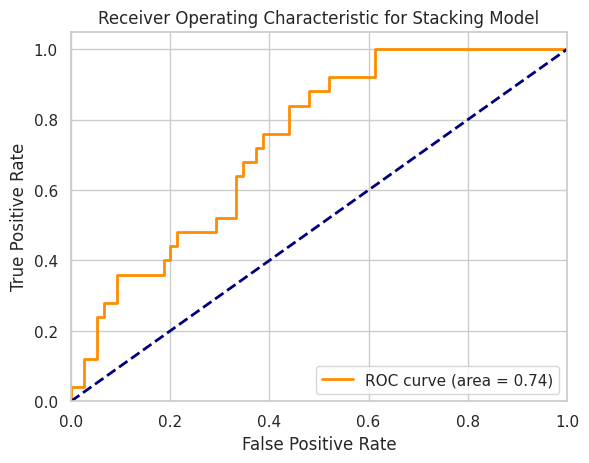

In [276]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Список базовых моделей для стекинга
base_models = [
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(random_state=SEED)),
    ('SVM', SVC(random_state=SEED, probability=True)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=SEED)),
    ('Random Forest', RandomForestClassifier(random_state=SEED))
]

# Мета-классификатор для стекинга
meta_model = LogisticRegression(random_state=SEED)

# Создание стекинга моделей
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Функция для оценки модели и вывода метрик
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    return accuracy, precision, recall, f1

# Вычисление и вывод метрик для стекинг модели
print("\nStacking Model:")

accuracy, precision, recall, f1 = evaluate_model(stacking_model, X_train, X_test, y_train, y_test)
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1:.4f}")

# Вывод classification report
print(classification_report(y_test, stacking_model.predict(X_test)))

# Вывод confusion matrix
cm = confusion_matrix(y_test, stacking_model.predict(X_test))
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative', 'Predicted Positive'],
                         index=['Actual Negative', 'Actual Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

# Вывод ROC-кривой и вычисление AUC
prob_pos = stacking_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prob_pos)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stacking Model')
plt.legend(loc="lower right")
plt.show()


### Объяснение:

1. **Создание ансамбля голосования**: Мы создаем ансамбль с помощью `StackingClassifier` из библиотеки `sklearn`, указывая список моделей.

2. **Обучение и оценка ансамбля**: Мы обучаем ансамбль на обучающих данных и оцениваем его производительность на тестовых данных, используя метрики точности, precision, recall и F1-score, а также выводим classification report и confusion matrix.

3. **Результаты**: Ансамбль может показать улучшенную производительность по сравнению с отдельными моделями за счет усреднения предсказаний и уменьшения вариации.



Давайте разберем интерпретацию результатов для модели стекинга, которая была представлена:

### Модель стекинга

- **Точность (Accuracy)**: 76.00%
- **Точность (Precision)**: 54.55%
- **Полнота (Recall)**: 24.00%
- **F1-мера (F1-score)**: 33.33%
- **AUC**: 0.7371

**Интерпретация**:
- **Accuracy (Точность)**: 76.00% означает, что 76 из 100 предсказаний были верными.
- **Precision (Точность)**: 54.55% говорит о том, что из всех предсказанных как положительные случаи (класс 1), только 54.55% действительно были положительными.
- **Recall (Полнота)**: 24.00% означает, что модель смогла обнаружить только 24.00% всех фактических положительных случаев.
- **F1-score (F1-мера)**: 33.33% — среднее гармоническое между точностью и полнотой. Это показатель сбалансированности между точностью и полнотой.
- **AUC**: 0.7371 является мерой качества модели, которая учитывает как полноту, так и специфичность модели. Значение 0.7371 указывает на среднюю способность модели различать между классами.

#### Детальный анализ по классам:
- **Класс 0 (отрицательный класс)**:
  - Точность: 79%
  - Полнота: 93%
  - F1-мера: 85%
  
  Эти метрики показывают, что модель хорошо справляется с предсказанием отрицательных случаев (класс 0), достигая высокой точности и полноты.

- **Класс 1 (положительный класс)**:
  - Точность: 55%
  - Полнота: 24%
  - F1-мера: 33%
  
  Для положительных случаев (класс 1) модель показывает низкую полноту и умеренную точность. Это означает, что модель не очень хорошо обнаруживает положительные случаи и может ошибочно классифицировать некоторые отрицательные случаи как положительные.

### Выводы:
Модель стекинга в целом имеет достаточно высокую общую точность (76%), что хорошо, но её производительность в обнаружении положительных случаев (класс 1) требует дальнейших улучшений. Особое внимание следует уделить увеличению полноты для класса 1, чтобы улучшить способность модели правильно обнаруживать положительные случаи.

Использование модель для новых данных:

In [277]:
# Аналогичный текст для предобработки и предсказаний
similar_text = """WASHINGTON -- The Federal Reserve raised short-term interest rates today, citing a strong labor market and inflation pressures. The Fed increased its benchmark overnight lending rate by a quarter percentage point to a range of 2% to 2.25%. This is the third rate hike this year. Fed Chairman Jerome Powell stated that further gradual increases are likely. The decision reflects the Fed's confidence in the strength of the U.S. economy, despite recent volatility in financial markets."""

# Создание экземпляра TextPreprocessor
preprocessor = TextPreprocessor()

# Предобработка аналогичного текста
processed_similar_text = preprocessor.preprocess(similar_text)


# Преобразование в TF-IDF вектор
similar_text_tfidf = tfidf_vectorizer.transform([processed_similar_text])

# Преобразование вектора TF-IDF в массив
tfidf_array = similar_text_tfidf.toarray()

# Предсказание с использованием stacking_model
prediction = stacking_model.predict(tfidf_array)

print(f"Stacking Model Prediction: {prediction}")

Stacking Model Prediction: [1]
